<a id="dimreduction"></a>
# Dimensionality reduction -- feature engineering


## Why? The curse of dimensionality

High dimensional data is more frequent than one might first think, e.g., even a low resolution  grey scale image from the famous [MNIST datase](https://en.wikipedia.org/wiki/MNIST_database):

<a href="https://miro.medium.com/max/245/1*nlfLUgHUEj5vW7WVJpxY-g.png"><img src="https://drive.google.com/uc?export=view&id=1-XrK7beC0beocLB_NufEmKVsBbCRko88" width=250px></a>

(Image source: [Image Classification in 10 Minutes with MNIST Dataset](https://towardsdatascience.com/image-classification-in-10-minutes-with-mnist-dataset-54c35b77a38d))

has 784 dimensions, as it contains intensity information for each of its $28\times 28 = 784$ pixels. Image processing is far from being the only area with high-dimensional data. For instance, the frequently used  "bag of words" representation of text documents in NLP uses a separate dimension for each word in the data set's vocabulary.

A high dimensional feature space is problematic for a number of reasons:

### Problems for visualization and exploration

We are simply not adapted to handle larger dimensional data well:
+ We are very good at recognizing patterns visually in 2 and 3 dimensional data, but we cannot really handle higher dimensional spaces.
+ A large number of our geometrical intuitions are not transferable to high dimensional spaces.

### Problems for ML algorithms 

+ For many supervised learning algorithms the number of examples needed to achieve a given level of accuracy grows exponentially with the number of dimensions (precision is proportional to data density in the feature space). $\Rightarrow$ **Simply adding new features without additional data leads to overfitting!**

+ More concretely, **_distances_ in the feature space on which many ML algorithms are based tend to be less and less discriminative** as the number of dimensions grow. Concretely,  the effective variance \[variance/max distance\]) for the same number of uniformly distributed points in a unit cube converges to 0 as the number of dimensions grows. 


### A few cautionary tales

Consider the following table, which shows the size of a hypercube that covers the given $f$ fraction of the volume of a $[0,1]^D$ unit hypercube for a number of $D$ dimensions ($\sqrt[D]{f}$):

In [ ]:
import pandas as pd

dims = list(range(1,11))
fracs = [0.2, 0.01, 0.001,0.0001]
result = []
for frac in fracs:
    result.append([frac**(1/dim) for dim in dims])
pd.DataFrame(result, columns = ["f"] +[f"{dim} dims" for dim in dims[1:]])

,f,2 dims,3 dims,4 dims,5 dims,6 dims,7 dims,8 dims,9 dims,10 dims
0,0.2000,0.447214,0.584804,0.668740,0.724780,0.764724,0.794597,0.817765,0.836251,0.851340
1,0.0100,0.100000,0.215443,0.316228,0.398107,0.464159,0.517947,0.562341,0.599484,0.630957
2,0.0010,0.031623,0.100000,0.177828,0.251189,0.316228,0.372759,0.421697,0.464159,0.501187
3,0.0001,0.010000,0.046416,0.100000,0.158489,0.215443,0.268270,0.316228,0.359381,0.398107


#### Increasing sample requirements

The figures show that if we train an ML algorithm using one feature, we need 20% of the population to cover 20% of the feature space; but if we start adding new features, then we need dramatically more samples to maintain the same amount of coverage on the feature space: concretely, even for 3 features **we'd need almost 60% of the population in each dimension to cover 20% of the feature space**:

<a href="http://www.visiondummy.com/wp-content/uploads/2014/04/curseofdimensionality.png"><img src="https://drive.google.com/uc?export=view&id=1rZ3tRLxGoDRi4KgHTwaRUi5L_BSPGMx-"></a>

([image source](http://www.visiondummy.com/2014/04/curse-dimensionality-affect-classification/))

#### Problems with neighborhood-based methods

Let's suppose that using a KNN-like approach we predict the label of an input which is uniformly distributed in $[0,1]^D$ on the basis of the labels of examples in a small hypercube around it which contains an $f$ fraction of the examples. As the table shows, for $D=10$ dimensions and $f=0.01$ the "small" hypercube's size will be 0.63, that is, **we will not really use _local_ information for determining the label** at all. (The size is slightly more than 0.5 even for $f=0.001$.)

(The example is from Murphy, Machine Learning:  A probabilistic perspective (MIT, 2012))

#### Samples are pushed to the corners

Another strange effect of high dimensionality is that the ratio of normal/central examples that are close to the centroid of the population radically decreases, because of the strange behavior of hyperspheres. E.g., considering again a $[0,1]^D$ feature space and an inscribed hypersphere with a $0.5$ radius, the volume of the hypesphere, and consequently the ratio of central examples tends to 0 (even though the spheres touch all sides of the hypercubes they are inscibed in):

<a href="http://www.visiondummy.com/wp-content/uploads/2014/04/sparseness.png"><img src="https://drive.google.com/uc?export=view&id=1kud-R8BRUkKqSDxchlb5ZUIwuvfAHzQ2"></a>

<a href="http://www.visiondummy.com/wp-content/uploads/2014/04/hypersphere.png"><img src="https://drive.google.com/uc?export=view&id=1eXFwO8Kalj2xUdIXryuj42RzoVvWBpDm"></a>

([image source](http://www.visiondummy.com/2014/04/curse-dimensionality-affect-classification/))

#### Does this mean that ML algorithms are hopeless already for ~10 features?

Fortunately, no -- notice that the cautionary tales all assumed that the data is more or less _uniformly distributed_ in the high-dimensional space. Frequently, this is not the case: to return to our MNIST example, even a cursory glance at the examples:

<a href="https://upload.wikimedia.org/wikipedia/commons/thumb/2/27/MnistExamples.png/220px-MnistExamples.png"><img src="https://drive.google.com/uc?export=view&id=1KavtxQVBVNy7WcwSAH5hVBzV5eKXy9xI" width="500px"></a>

(Image source: [Wikipedia](https://en.wikipedia.org/wiki/MNIST_database))

shows that the data points are _not_ uniformly distributed in the 784 dimensional space, e.g., many positions are always white. The lesson is rather that high dimensional spaces can behave very counterintuitively, can cause problems for ML algorithms, and the **clever exploitation of the data distribution** (e.g., dense lower dimensional subspaces) is **highly important for the performance of ML methods**.

#### Further reading
The discussion here used the images and in a large part followed the exposition of the [The Curse of Dimensionality in classification](http://www.visiondummy.com/2014/04/curse-dimensionality-affect-classification/) by Vincent Spruyt at http://www.visiondummy.com which is worth reading in full.

## Types of dimensionality reduction

### Feature selection/filtering
Decrease number of features by dropping less useful ones 
- e.g. some features might have information content that is contained in other features

Good indicators:
  - **high correlation** between pairs of features
  - **low information gain**  in terms of both featues vs. only one

"A __first group of methods__ take advantage of this knowledge and try to identify the best subset of features for the specific model class. This group can be further split into __wrapper__ and __embedded methods__. Wrappers employ the learning process as a subroutine of the feature selection process, using the validation error of the trained model as a score to decide whether to keep or discard a feature. Clearly, this potentially leads to good generalization capabilities at the cost of iterating the learning process multiple times, which might become impractical for high-dimensional datasets. Embedded methods, still assume the knowledge of the model class, but the feature selection and the learning process are carried out together (a remarkable example is in which a generalization bound on the SVM is optimized for both learning the features and the model). Although less demanding than wrappers from a computational standpoint, embedded methods heavily rely on the peculiar properties of the model class. 

A __second group of methods__ do not incorporate knowledge of the model class. These approaches are known as __filters__. Filters perform the feature selection using scores that are independent of the underlying learning model. For this reason, they tend not to overfit but they might result less effective than wrappers and embedded methods as they are general across all the possible model classes. From a computational perspective, filters are the most efficient feature selection methods."   

More details [here](https://arxiv.org/abs/1907.07384), [here](https://thuijskens.github.io/2017/10/07/feature-selection/) and [here](https://arxiv.org/abs/2107.08066).

In fact, the embedded methods can have some connections to L1 regularization, see more eg. [here](http://wittawat.com/pages/files/L1LSMI.pdf).

### Feature projection

**Replace certain or all features with a lower number of new ones**, containing (most of the) **useful information of original** features.

Data points in the original feature space represented in a new feature space .
- New feature values are __projections__ of the data points onto the axes of the new space
- Concept of "projection" not necessarily linear.


In [ ]:
# Iris dataset
from sklearn import datasets

iris = datasets.load_iris()
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [ ]:
# Data
import pandas as pd
import numpy as np

pd.DataFrame(data= np.c_[iris['data'], iris['target']], columns= iris['feature_names'] + ['target']).head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


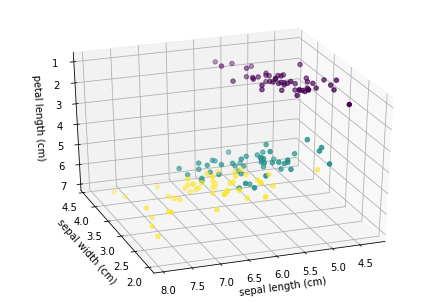

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

X = iris.data[:, :4]
Y = iris.target

# we only visualize three features at once
fig = plt.figure()
ax = Axes3D(fig, elev=-150, azim=110)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=Y)
ax.set_xlabel(iris['feature_names'][0])
ax.set_ylabel(iris['feature_names'][1])
ax.set_zlabel(iris['feature_names'][2])
plt.show()

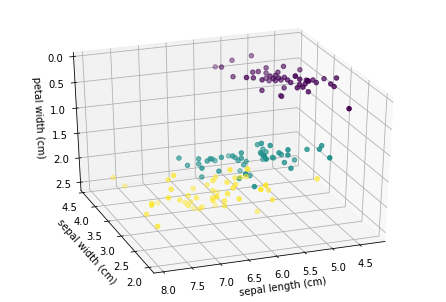

In [ ]:
fig = plt.figure()
ax = Axes3D(fig, elev=-150, azim=110)
ax.scatter(X[:, 0], X[:, 1], X[:, 3], c=Y)
ax.set_xlabel(iris['feature_names'][0])
ax.set_ylabel(iris['feature_names'][1])
ax.set_zlabel(iris['feature_names'][3])

plt.show()

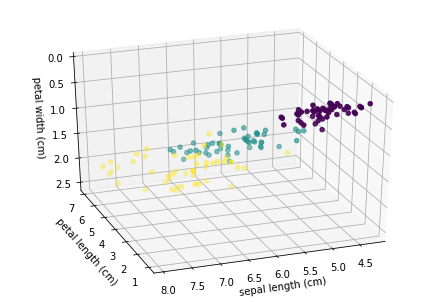

In [ ]:
fig = plt.figure()
ax = Axes3D(fig, elev=-150, azim=110)
ax.scatter(X[:, 0], X[:, 2], X[:, 3], c=Y)
ax.set_xlabel(iris['feature_names'][0])
ax.set_ylabel(iris['feature_names'][2])
ax.set_zlabel(iris['feature_names'][3])
plt.show()

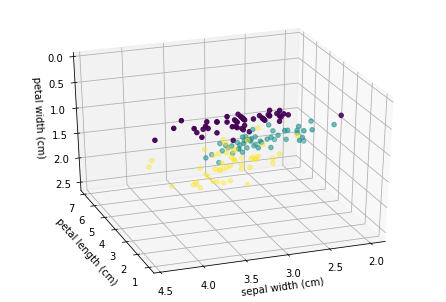

In [ ]:
fig = plt.figure()
ax = Axes3D(fig, elev=-150, azim=110)
ax.scatter(X[:, 1], X[:, 2], X[:, 3], c=Y)
ax.set_xlabel(iris['feature_names'][1])
ax.set_ylabel(iris['feature_names'][2])
ax.set_zlabel(iris['feature_names'][3])
plt.show()

## Feature projection methods

## Linear methods

- Transformation into new feature space linear
- Find new and more useful axes that can be expressed as linear combinations of basis vectors of old feature space

### Principal Component Analysis (PCA)

- One of the most important linear dimension reduction methods for continuous features
- Finds set of **orthogonal directions** in the old feature space **along which the variance of the data is the largest **
-> Minimizes the covariance of the data between the new directions.

The **variance** of an $A=\{a,\dots,a_{N}\}$ of a data set can be defined here as

$$
\sigma^2_A=\frac{1}{N}\sum_i (a_i - \bar{a})^2
$$

and the **covariance** of values $A=\{a_1,\dots,a_{N}\}$ and $B=\{b_1,\dots,b_{N}\}$ is 

$$
\sigma^2_{AB}=\frac{1}{N}\sum_i (a_i - \bar{a})(b_i - \bar{b})
$$

where $\bar a$ and $\bar b$ signify the means of $A$ and $B$, respectively.


<a href="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f5/GaussianScatterPCA.svg/720px-GaussianScatterPCA.svg.png"><img src="https://drive.google.com/uc?export=view&id=1BrMrd0vb19qF_hWq1XJ0aA8ge0XEbRYQ" width="500"></a>


([source](https://en.wikipedia.org/wiki/Principal_component_analysis))


- **High variance along axes** ensures that new features have high information content
- **Low covariance between projections (guaranteed by orthogonality) onto the new axes** means that none of the new features contain  highly correlated information







#### Intuitive algorithm
1.  Find a direction in the feature space along which variance is maximal. This will be the first new basis vector (principal component).

2.  Find  another  direction  along  which  variance  is  maximized and which is orthogonal to all basis vectors found so far.

3.  Repeat Step 2 until all $m$ vectors of the basis are found.


#### Using PCA for dimension reduction
- New basis vectors PCA produces are ordered by variance
- Drop components with low variance, because they can be considered to be (mainly) noise 

<a href="http://www.nlpca.org/fig_pca_principal_component_analysis.png"><img src="https://drive.google.com/uc?export=view&id=1T-LhhvX6jv9UO07RO29DpkQ3la9iWUoG"></a>

(source: http://nlpca.org)

In [ ]:
# data size
print(X.shape)

(150, 4)


In [ ]:
# PCA transformation into 2 dims
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

print(X_pca.shape)

(150, 2)


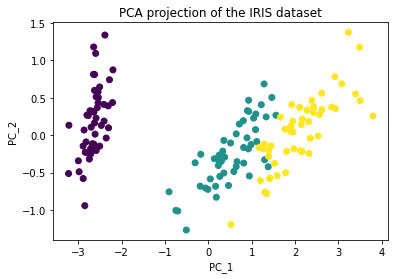

In [ ]:
# Plot, 2D
plt.figure()
plt.scatter(X_pca[:, 0], X_pca[:,1], c=Y)
plt.xlabel('PC_1')
plt.ylabel('PC_2')
plt.title('PCA projection of the IRIS dataset')
plt.show()

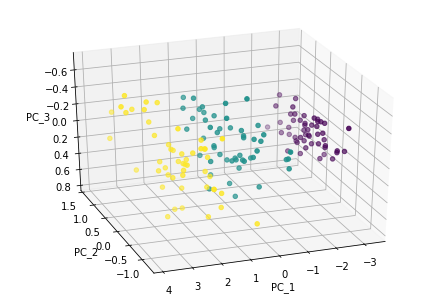

In [ ]:
# Transform & plot, 3D
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

fig = plt.figure()
ax = Axes3D(fig, elev=-150, azim=110)
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=Y)
ax.set_xlabel('PC_1')
ax.set_ylabel('PC_2')
ax.set_zlabel('PC_3')
plt.show()

In [ ]:
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(pca.components_.shape[0])], index=iris.feature_names)\
          .sort_values("PC1", ascending=False, key=lambda x: abs(x))
display(loadings)

,PC1,PC2,PC3
petal length (cm),0.856671,-0.173373,0.076236
sepal length (cm),0.361387,0.656589,-0.582030
petal width (cm),0.358289,-0.075481,0.545831
sepal width (cm),-0.084523,0.730161,0.597911


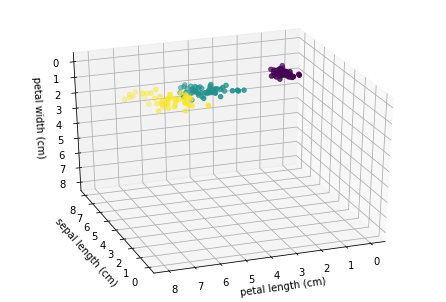

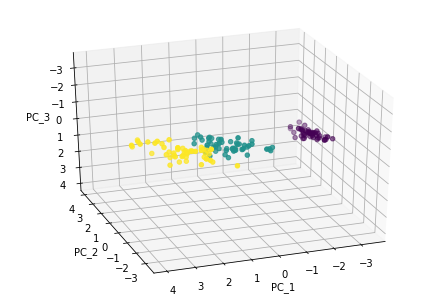

In [ ]:
# Plot, 3D
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(pca.components_.shape[0])], index=iris.feature_names)\
          .sort_values("PC1", ascending=False, key=lambda x: abs(x))
feat_idxs = [iris["feature_names"].index(x) for x in loadings.index[:pca.n_components_]]

xmin = X[:,feat_idxs].min() - 0.5
xmax = X[:,feat_idxs].max() + 0.5

fig = plt.figure()
ax = Axes3D(fig, elev=-150, azim=110)
ax.scatter(X[:, feat_idxs[0]], X[:, feat_idxs[1]], X[:, feat_idxs[2]], c=Y)
ax.set_xlim(xmin,xmax)
ax.set_ylim(xmin,xmax)
ax.set_zlim(xmin,xmax)
ax.set_xlabel(iris["feature_names"][feat_idxs[0]])
ax.set_ylabel(iris["feature_names"][feat_idxs[1]])
ax.set_zlabel(iris["feature_names"][feat_idxs[2]])
plt.show()


xmin = X_pca.min() - 0.5
xmax = X_pca.max() + 0.5

fig = plt.figure()
ax = Axes3D(fig, elev=-150, azim=110)
ax.set_xlim(xmin,xmax)
ax.set_ylim(xmin,xmax)
ax.set_zlim(xmin,xmax)
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=Y)
ax.set_xlabel('PC_1')
ax.set_ylabel('PC_2')
ax.set_zlabel('PC_3')

plt.show()

#### PCA diagonalizes the covariance matrix  (not essential to understand in detail)

- Mathematically, PCA finds new orthonormal basis  in which the __covariance matrix__  of the data is diagonal (all non-diagonal elements are 0). 
- Covariance matrix for a dataset $\mathbf X=\{\mathbf x_1,\dots, \mathbf x_N\}$ of $m$-dimensional vectors with data for features $F_1,\dots,F_{m}$ is the matrix 

$$ \text{Cov}(\mathbf X) = \frac{1}{N}\sum_{i=1}^N(\mathbf x_i-\bar{\mathbf x})(\mathbf x_i-\bar{\mathbf x})^T=
\begin{bmatrix}
\sigma^2_{F_1} &\cdots &\sigma^2_{F_1 F_{m}}\\
\vdots & \ddots & \vdots \\
\sigma^2_{F_m F_{1}} & \cdots & \sigma^2_{F_m}
\end{bmatrix}
$$
that is, for each cell in row $i$ and column $j$ it contains the covariance of $F_i$ and $F_j$ -- consequently  the diagonal of the matrix contains the _variances_ of the data for each feature.

#### Explained variance by component

- When we switch to new feature space produced by PCA, say from features $F_1, \dots, F_m$ to $P_1,\dots, P_m$, the  _total variance_ of our data, which is the **sum of the variances along the features remains unchanged** (given no components are dropped):

$$
\sum_i\sigma^2_{F_i}=\sum_i\sigma^2_{P_i}
$$

- **Only the distribution of total variance among features changes**. 
- Accordingly, it makes sense to talk about *how much of the total variance of the data is along ("explained by") a PCA component/feature $P_k$*: this value is simply $$\frac{\sigma^2_{P_k}}{\sum_i\sigma^2_{P_i}}$$.

Customary to **use the "explained variance" percentage of components** to decide which one can be omitted to reduce dimensionality.

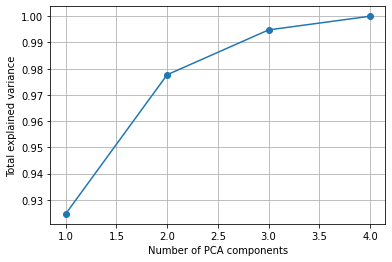

In [ ]:
# Decreasing variance
pca = PCA().fit(X)
plt.plot(list(range(1,pca.n_components_+1)), np.cumsum(pca.explained_variance_ratio_), marker="o")
plt.grid()
plt.xlabel('Number of PCA components')
plt.ylabel('Total explained variance')
plt.show()

#### Reconstructing the original representation from the PCA representation

- Mapping from old feature space to new provided by PCA can be reversed 
- Using the PCA components and the new representations the original data can be reconstructed, at least approximately; e.g. with one component:

<a href="http://alexhwilliams.info/itsneuronalblog/img/pca/rank_one.png"><img src="https://drive.google.com/uc?export=view&id=1wheGkUUxAic4c2gwJ6Xj5IMKtpCyr5BE" width="900"></a>

- As more and more components are used the approximation gets more precise 
- Using all components we are guaranteed to get back exactly the original data 
- Otherwise data points replaced with their projections on the subspace determined by chosen components
- If the reconstruction not precise, PCA representation __lossy compressions__ of the original data

<a href="http://alexhwilliams.info/itsneuronalblog/img/pca/pca_3.png"><img src= "https://drive.google.com/uc?export=view&id=1TN302dZz31WZz2cEaj7VJOdDDt1xhpAq" width="900"></a>

(source: [Everything you did and didn't know about PCA](http://alexhwilliams.info/itsneuronalblog/2016/03/27/pca/))


- Reconstruction of PCA and other linear methods useful **measure of the quality of a lower dimensional representation**: 
- Reconstruct original data and measure loss, i.e., difference between reconstructed data and the original, i.e., for data $\mathbf X$, lower dimensional representations $\mathbf W$ and components $\mathbf C$ consider
 
$$
\rho(\mathbf X - \mathbf W \mathbf C)
$$
$\rho$ is an appropriate **measure on matrixes** 

- Typical choice is $\|\cdot\|_F^2$, _Frobenius matrix norm_:
- The sum of squares of all elemens in a matrix, i.e.,

$$
\| \mathbf{A} \|_F^2 = \sum_{i} \sum_{j} a_{ij}^2.$$

It can be proven that the components provided by PCA minimize this type of loss.

In [ ]:
del iris

In [ ]:
from sklearn.datasets import load_digits
digits = load_digits()
print(digits.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 1797
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

In [ ]:
digits.data.shape

(1797, 64)

In [ ]:
def plot_digits(data):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(8, 8),
                  cmap='binary', interpolation='nearest',
                  clim=(0, 16))
    plt.show()

In [ ]:
X = digits.data
pca = PCA(2)  # project from 64 to 2 dimensions
X_pca = pca.fit_transform(X)
print(X.shape)
print(X_pca.shape)

(1797, 64)
(1797, 2)


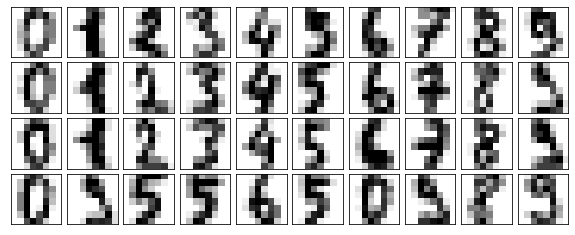

In [ ]:
plot_digits(X)

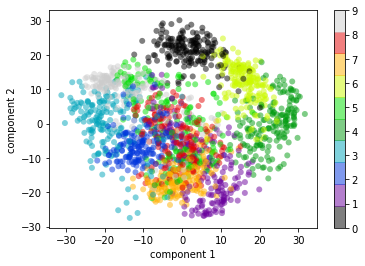

In [ ]:
plt.scatter(X_pca[:, 0], X_pca[:, 1],
            c=digits.target, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();
plt.show()

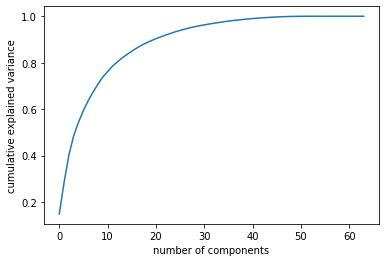

In [ ]:
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.show()

In [ ]:
pca = PCA(0.90).fit(digits.data)
print(pca.n_components_)

21


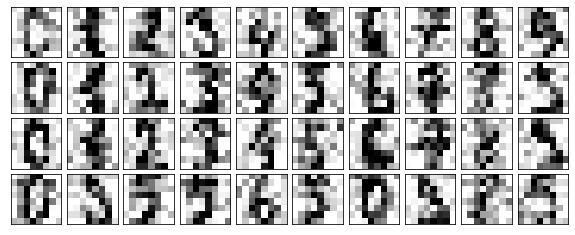

In [ ]:
np.random.seed(42)
noisy = np.random.normal(X, 4)
plot_digits(noisy)

In [ ]:
pca5 = PCA(0.50).fit(X)
print(pca5.n_components)

0.5


In [ ]:
pca5 = PCA(0.50).fit(X)
print(pca5.components_.shape)

(5, 64)


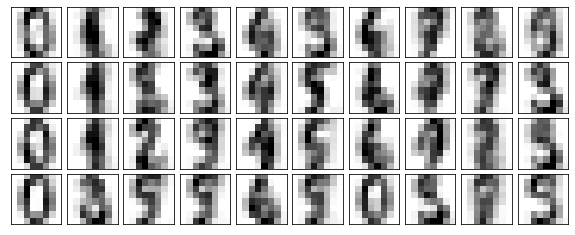

In [ ]:
components = pca5.transform(noisy)
filtered = pca5.inverse_transform(components)
plot_digits(filtered)

In [ ]:
del digits

In [ ]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


In [ ]:
pca = PCA(150, svd_solver='randomized')
pca.fit(faces.data)

PCA(copy=True, iterated_power='auto', n_components=150, random_state=None,
    svd_solver='randomized', tol=0.0, whiten=False)

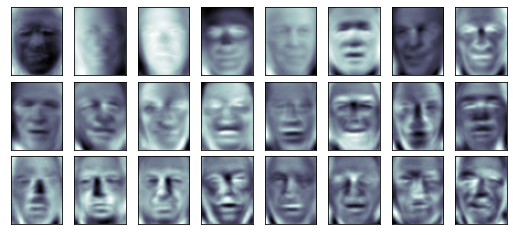

In [ ]:
fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(62, 47), cmap='bone')
    
plt.show()

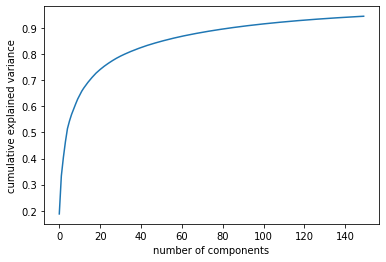

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.show()

In [ ]:
components = pca.transform(faces.data)
projected = pca.inverse_transform(components)

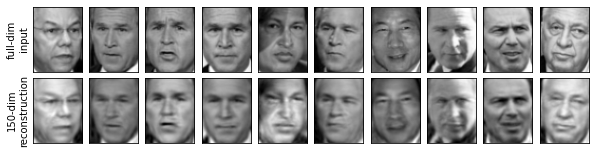

In [ ]:
fig, ax = plt.subplots(2, 10, figsize=(10, 2.5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
    ax[0, i].imshow(faces.data[i].reshape(62, 47), cmap='binary_r')
    ax[1, i].imshow(projected[i].reshape(62, 47), cmap='binary_r')
    
ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel('150-dim\nreconstruction');

plt.show()

#### Further reading
+ [A very good technical PCA tutorial by Jonathon Shlens](https://arxiv.org/abs/1404.1100)

### Sparse PCA

- Disadvantage of PCA: difficult to interpret results, since produced new features typically linear combinations of _all_ original features
- Sparse PCA tries to solve problem by trying to find components which maximize variance but are sparse in the sense that they combine a low number features 

+ Sparsity is typically implemented in the objective function as an L1 penalty.
+ The orthogonality requirement of PCA is dropped.
+ Because of the L1 penalty and the connection between variance maximization and LSE (least square error) minimization problem closely related to LASSO linear regression, and is solved with similar methods

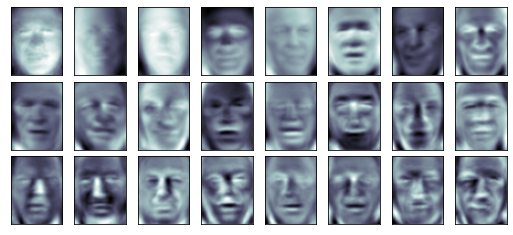

In [ ]:
from sklearn.decomposition import SparsePCA
sparsePca = SparsePCA(n_components=64, alpha=0, ridge_alpha=1e-6, max_iter=200, tol=1e-3)
sparsePca.fit(faces.data)

fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(sparsePca.components_[i].reshape(62, 47), cmap='bone')
    
plt.show()

#### Further reading

An introduction to PCA and its sparse variants:
[Everything you did and didn't know about PCA](http://alexhwilliams.info/itsneuronalblog/2016/03/27/pca/)


### Non-negative Matrix Factorization (NMF)

- Even if all values in original data non-negative, PCA and its variants frequently produce components and new representations with _negative values_
- Often undesirable: component subtraction difficult to interpret

Technically, NMF

- Solves the factorization problem $X \approx W \times H$ where $X$ is the input data matrix, $W$ is the new representation and $H$ is the component ("hidden factor") matrix.
- Often used in conjunction with sparsity inducing regularization (e.g., L1 and L2).
- The objective is to minimize the reconstruction error $||X-WH||^2_F$
- There is no closed form, analytical solution, special iterative algorithms are used, e.g., GD variants.
- The factorization is not unique, since if $B$ is invertible and $B$ and $B^{-1}$ are non-negative then $W\times H =WB\times B^{-1}H$ is also solution.



#### PCA vs NMF:

(red squares represent negative values)

<a href="http://drive.google.com/uc?export=view&id=15c9GUhTki91dujRIrfiUpHvHzxpyXYjO"><img src="https://drive.google.com/uc?export=view&id=13ajGXC2sOZwFRFH4SXPLcoKbhZMPs1-X"></a>

<a href="http://drive.google.com/uc?export=view&id=1AuQw9YU2QbZ8GuP5CS-zZZzARW-j9uzN"><img src="https://drive.google.com/uc?export=view&id=1VRpj1z-NbCakl9fQjvXJDjvZdK2bvjf_"></a>

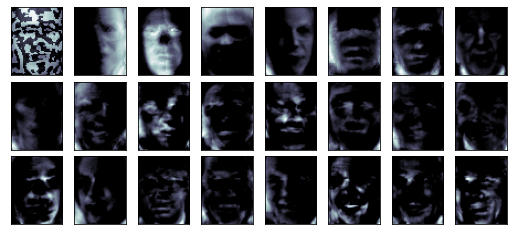

In [ ]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)

from sklearn.decomposition import NMF
nmf = NMF(n_components=150, init='nndsvda', tol=5e-3)
nmf.fit(faces.data)

fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(nmf.components_[i].reshape(62, 47), cmap='bone')
    
plt.show()

### Factor Analysis
- Factor analysis is a statistical method used to describe variability among observed, correlated variables in terms of a **potentially lower number of unobserved variables called factors**. 
- For example, it is possible that variations in six observed variables mainly reflect the variations in two unobserved (underlying) variables.
- The **observed variables are modelled as linear combinations of the potential factors, plus "error" terms**.
- Factor analysis aims to find independent latent variables.


Exploratory factor analysis is used to investigate whether any factors are underlying the covariance structure among the manifest variables without making assumptions about which factors are related to which of the manifest variables.

The model used in EFA is called the common factor model, that is, a set of factors contribute to the covariance among the manifest variables. In the case of Spearman’s single factor model, suppose the manifest variables are X=(X1,…,Xp). Then the single factor model is

$$
\begin{array}{ccc}
X_{1}-\mu_{1} & = & \lambda_{1} f+u_{1} \\
\vdots & & \vdots \\
X_{p}-\mu_{p} & = & \lambda_{p} f+u_{p}
\end{array}
$$


Each Xi is a vector with values across different subjects. We are subtracting it with their respective means to normalize it. Here f is an unobserved random variable called the common factor, λi (called loadings; unknown) quantifies the strength of the association between the common factor and the i-th manifest variable Xi, and ui is an unobserved random variable that describes the part of Xi not explained by the common factor f. This model can be generalized to accommodate multiple factors as well. For example, a three-factor model can be written as below:


$$
\begin{array}{c}
X_{1}-\mu_{1}=\lambda_{11} f_{1}+\lambda_{12} f_{2}+\lambda_{13} f_{3}+u_{1} \\
\vdots \\
X_{p}-\mu_{p}=\lambda_{p 1} f_{1}+\lambda_{p 2} f_{2}+\lambda_{p 3} f_{3}+u_{p}
\end{array}
$$

where we now have three common factors, f1,f2 and f3. The loadings λij quantifies the relationship between the j-th common factor, fj, with the i-th manifest variable, Xi.
Our goal is to estimate/predict all the unknown components on the right-hand side of the equations.


Source: [Medium-Factor Analysis](https://medium.com/@nv199/factor-analysis-c139e7dcd0ba)

#### Factor Analysis - Geometric Interpretation (broadly)

For those interested in the geometric interpretation, the [Wikipedia article on factor analysis](https://en.wikipedia.org/wiki/Factor_analysis) offers a good description.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/56/FactorPlot.svg/1280px-FactorPlot.svg.png" height=250px>
 
> The parameters and variables of factor analysis can be given > a geometrical interpretation. The data $({\displaystyle z_> {ai}}z_{ai})$, the factors $({\displaystyle F_{pi}}F_{pi})$ > and the errors $({\displaystyle \varepsilon _{ai}}> \varepsilon _{ai})$ can be viewed as vectors in an $> {\displaystyle N_{i}}N_{i}$-dimensional Euclidean space > (sample space), represented as ${\displaystyle \mathbf {z} _> {a}}\mathbf {z} _{a}$, ${\displaystyle \mathbf {F} _{p}}> \mathbf {F} _{p}$ and ${\displaystyle {\boldsymbol > {\varepsilon }}_{a}}{\boldsymbol {\varepsilon }}_{a}$ > respectively. Since the data are standardized, the data > vectors are of unit length $({\displaystyle \mathbf {z} _{a}> \cdot \mathbf {z} _{a}=1}\mathbf {z} _{a}\cdot \mathbf {z} _> {a}=1)$. The factor vectors define an ${\displaystyle N_{p}}> N_{p}$-dimensional linear subspace (i.e. a hyperplane) in > this space, upon which the data vectors are projected > orthogonally. This follows from the model equation
> 
> 
> $${\displaystyle \mathbf {z} _{a}=\sum _{p}\ell _{ap}\mathbf > {F} _{p}+{\boldsymbol {\varepsilon }}_{a}}\mathbf {z} _{a}> =\sum _{p}\ell _{ap}\mathbf {F} _{p}+{\boldsymbol > {\varepsilon }}_{a}$$
> 
> 
> 
> and the independence of the factors and the errors: $> {\displaystyle \mathbf {F} _{p}\cdot {\boldsymbol > {\varepsilon }}_{a}=0}\mathbf {F} _{p}\cdot {\boldsymbol > {\varepsilon }}_{a}=0$. In the above example, the hyperplane > is just a 2-dimensional plane defined by the two factor > vectors. The projection of the data vectors onto the > hyperplane is given by
> 
> 
> $${\displaystyle {\hat {\mathbf {z} }}_{a}=\sum _{p}\ell _> {ap}\mathbf {F} _{p}}{\hat {\mathbf {z} }}_{a}=\sum _{p}\ell > _{ap}\mathbf {F} _{p}$$
> 
> 
> and the errors are vectors from that projected point to the > data point and are perpendicular to the hyperplane. The goal > of factor analysis is to find a hyperplane which is a "best > fit" to the data in some sense, so it doesn't matter how the > factor vectors which define this hyperplane are chosen, as > long as they are independent and lie in the hyperplane. We > are free to specify them as both orthogonal and normal $(> {\displaystyle \mathbf {F} _{p}\cdot \mathbf {F} _{q}=\delta > _{pq}}\mathbf {F} _{p}\cdot \mathbf {F} _{q}=\delta _{pq})$ > with no loss of generality. After a suitable set of factors > are found, they may also be arbitrarily rotated within the > hyperplane, so that any rotation of the factor vectors will > define the same hyperplane, and also be a solution. As a > result, in the above example, in which the fitting > hyperplane is two dimensional, if we do not know beforehand > that the two types of intelligence are uncorrelated, then we > cannot interpret the two factors as the two different types > of intelligence. Even if they are uncorrelated, we cannot > tell which factor corresponds to verbal intelligence and > which corresponds to mathematical intelligence, or whether > the factors are linear combinations of both, without an > outside argument.
> 
> 
> The data vectors ${\displaystyle \mathbf {z} _{a}}\mathbf > {z} _{a}$ have unit length. The correlation matrix for the > data is given by ${\displaystyle r_{ab}=\mathbf {z} _{a}> \cdot \mathbf {z} _{b}}r_{ab}=\mathbf {z} _{a}\cdot \mathbf > {z} _{b}$. The correlation matrix can be geometrically > interpreted as the cosine of the angle between the two data > vectors ${\displaystyle \mathbf {z} _{a}}\mathbf {z} _{a}$ > and ${\displaystyle \mathbf {z} _{b}}\mathbf {z} _{b}$. The > diagonal elements will clearly be 1's and the off diagonal > elements will have absolute values less than or equal to > unity. The "reduced correlation matrix" is defined as
> 
> $${\hat {r}}_{ab}={\hat {\mathbf {z} }}_{a}\cdot {\hat > {\mathbf {z} }}_{b}.$$
> 
> 
> The goal of factor analysis is to choose the fitting > hyperplane such that the reduced correlation matrix > reproduces the correlation matrix as nearly as possible, > except for the diagonal elements of the correlation matrix > which are known to have unit value. In other words, the goal > is to reproduce as accurately as possible the > cross-correlations in the data. Specifically, for the > fitting hyperplane, the mean square error in the > off-diagonal components
> 
> $$\varepsilon ^{2}=\sum _{a,b\neq a}\left(r_{ab}-{\hat {r}}_> {ab}\right)^{2}$$
> 
> 
> is to be minimized, and this is accomplished by minimizing > it with respect to a set of orthonormal factor vectors. It > can be seen that
> 
> $$r_{ab}-{\hat {r}}_{ab}={\boldsymbol {\varepsilon }}_{a}> \cdot {\boldsymbol {\varepsilon }}_{b}$$
> 
> The term on the right is just the covariance of the errors. > In the model, the error covariance is stated to be a > diagonal matrix and so the above minimization problem will > in fact yield a "best fit" to the model: It will yield a > sample estimate of the error covariance which has its > off-diagonal components minimized in the mean square sense. > It can be seen that since the $${\displaystyle {\hat {z}}_{a}> }{\hat {z}}_{a}$$ are orthogonal projections of the data > vectors, their length will be less than or equal to the > length of the projected data vector, which is unity. The > square of these lengths are just the diagonal elements of > the reduced correlation matrix. These diagonal elements of > the reduced correlation matrix are known as "communalities":
> 
> $$h_{a}^{2}={\hat {\mathbf {z} }}_{a}\cdot {\hat {\mathbf > {z} }}_{a}=\sum _{p}\ell _{ap}\ell _{ap}$$
> 
> Large values of the communalities will indicate that the > fitting hyperplane is rather accurately reproducing the > correlation matrix. The mean values of the factors must also > be constrained to be zero, from which it follows that the > mean values of the errors will also be zero.





### Linear Discriminant Analysis (LDA)

- **PCA is an "unsupervised" method** in the sense that it does not make use of a distinction of input and output variables/features (e.g. data to be classified and the correct class labels),
- **LDA** can be used for classified data points to find **directions/components in the feature space that have good classificatory properties**

#### LDA objective

Goal of LDA is to find (not necessarily orthogonal) directions in the feature space which simultaneously

- **maximise the distances between** the means of the classes
- **minimise the variance within** the classes

The number of new dimensions produced by LDA depends on the number of classes and the dimensionality of original feature space: 
- for $m$ classes and $n$ original features can produce a $\min(m-1, n)$ dimensional new feature space



##### For binary classification

For a binary classification problem LDA seeks a _single_ axis in the feature space which maximizes the following value:

$$\frac{(\tilde{\mu_1}-\tilde{\mu_2})^2}{\tilde{\sigma_1}^2+\tilde{\sigma_2}^2} $$

where $\tilde{\mu_1}$ and $\tilde{\mu_2}$ are the projections of the two class centroids on the axis, and $\tilde{\sigma_1}^2$ and $\tilde{\sigma_2}^2$ are the _variances_ of the data points of the two classes along the axis.


Reducing 2-dimensional feature space with 2 classes to 1 feature:
* **PCA** representation: in the direction of the highest variance
* **LDA** representation: where overlap between classes is smallest (within-class variance smallest, between-class distance highest)

<a href="https://i.stack.imgur.com/2A4bb.jpg"><img src="https://drive.google.com/uc?export=view&id=1stdcEkCHD2L8_K2nxSiOnzstmQK0KlKo" height=300px></a>

(image source: STAT 101C of UCLA via [Stack Exchange](https://stats.stackexchange.com/questions/161362/supervised-dimensionality-reduction))


##### Generalization for multiclass classification (can be jumped)

For $m>2$  classes the projections are no longer scalar, so in this case both the separation between the means of the classes and the within the class variances are represented as so called _scatter matrices_. For a given $c$ class containing the $\mathbf X_c = \{\mathbf x_1,\dots,\mathbf x_N\}$ data points with $\bar{\mathbf x}_c$ mean, the _within class scatter matrix_ is

$$S_w^c=\sum_{i=1}^N(\mathbf x_i-\bar{\mathbf x}_c)(\mathbf x_i-\bar{\mathbf x}_c)^T=N~\text{Cov}(\mathbf{X}_c)$$

while the _between classes scatter matrix_ for $c$ is

$$S_b^c=N(\bar{\mathbf x}_c-\bar{\mathbf x})(\bar{\mathbf x}_c-\bar{\mathbf x})^T$$

where $\bar{\mathbf x}$ is the mean of the whole dataset. With these definitions the LDA goal for $C=\{c_1,\dots,c_m\}$ classes is to find $m-1$ axes in the original feature space for which the scatter matrices of the data points' projections maximize

$$\frac{|\sum_{c\in C} S_b^c|}{|\sum_{c\in C} S_w^c|}$$

where the $|\cdot|$ matrix operator used to get scalar values for the nominator and denominator takes the determinant of the scatter matrixes providing a  kind of "sum total scatter".

<a href="https://i.stack.imgur.com/x1wle.jpg"><img src="https://drive.google.com/uc?export=view&id=1N1xNiiftzSOXgcci22MzaK6gR0Qnm160"></a>

(source: [StackExchange](https://stats.stackexchange.com/questions/22884/how-does-linear-discriminant-analysis-reduce-the-dimensions))

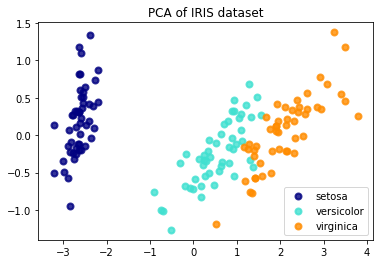

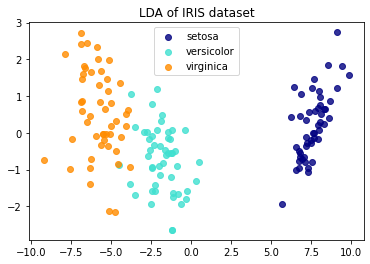

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

iris = datasets.load_iris()

X = iris.data
y = iris.target
target_names = iris.target_names

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(X, y).transform(X)

plt.figure(1)
colors = ['navy', 'turquoise', 'darkorange']
lw = 2

for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of IRIS dataset')

plt.figure(2)
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r2[y == i, 0], X_r2[y == i, 1], alpha=.8, color=color,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA of IRIS dataset')

plt.show()

#### Further reading

[Tharwat, Alaa, et al. "Linear discriminant analysis: A detailed tutorial." AI communications 30.2 (2017)](https://www.researchgate.net/publication/316994943_Linear_discriminant_analysis_A_detailed_tutorial)

### Differences between PCA, Factor Analysis and LDA

-	**LDA** =>  This method identifies components (i.e., linear combination of the observed variables) that **maximize class separation** (i.e. between-class variance) when such prior information is available (i.e., **supervised**). E.g., you have a training set containing a variable specifying the class of each observation.
-	**PCA** => Aims to find **components that account for maximum variance in the data** (including error and within-variable variance). Unlike LDA, it does not take into account class membership (i.e., **unsupervised**), and is used when such information is not available. Importantly, both LDA and PCA do not require any prior notion of how the variables are related among themselves, and the resulting components can not be interpreted in terms of an underlying construct.
-	**FA** => Tries to **uncover latent factors that account for the variance shared between the observed variables** (thus excluding error and within-variable variance). Ideally, the resulting latent factors represent interpretable underlying constructs. FA should be used when you assume that an underlying causal model induces covariance between several observed variables. Consequently, unlike PCA and LDA, the **observed variables are linear combinations of the estimated latent factors**.

Source: [What is the difference between PCA, FA and LDA?](https://www.researchgate.net/post/What_is_the_difference_between_PCA_FA_and_LDA)


## Nonlinear methods (Manifold learning)

Methods in this group don't linearly transform the data but still provide __embeddings__, that is, mappings from the original feature space into a different, lower dimensional space which are sensitive to the non-linear/only locally linear structure in data. These methods are _typically unsupervised_, they discover structure in the data without class labels or other type of supervised information.


### Stochastic Neighborhood Embedding (SNE and t-SNE)

SNE and t-SNE was developed in 2008 by van der Maaten and Hinton ([original paper](http://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf)) explicitly as a __method for visualization__: it maps the original dataset **into 2- or 3-dimensional space while trying to keep as much useful positional similarity information as possible**.

In contrast to traditional linear techniques  (e.g., PCA) that focus on keeping dissimilar points far apart, SNE focuses on keeping the low-dimensional representations of very similar points close together, which typically requires nonlinear mapping.

#### "vanilla" Stochastic Neighborhood Embedding (SNE)

The main idea of SNE is to **model the similarity** of point pairs in the feature space **by conditional probabilities**:

> "The similarity of datapoint $\mathbf x_j$ to datapoint $\mathbf x_i$ is the conditional probability that $\mathbf x_i$ would pick $\mathbf x_j$ as its neighbor if neighbors were picked in proportion to their probability density under a Gaussian centered at $\mathbf x_i$ ."

Accordingly, the (_not necessarily symmetrical_) similarity of a point $\mathbf x_j$ to  $\mathbf x_i$   is the conditional probability

$$p_{j|i} = \frac{f_i(\|\mathbf x_i-\mathbf x_j \|)}{\sum_{k\neq i}f_i(\|\mathbf x_i-\mathbf x_k \|)}$$

where we $f_{i}(\cdot)=\mathcal N(0, \sigma_i^2)$ is a Gaussian pdf. The goal of SNE is to 

* find the ideal $\sigma_i^2$ values for each $\mathbf x_i$ data point,
* for each $\mathbf x _i$ find a corresponding $\mathbf y_i$ in the target space such that the corresponding 

  $$q_{j|i} = \frac{g(\|\mathbf y_i-\mathbf y_j \|)}{\sum_{k\neq i}g(\|\mathbf y_i-\mathbf y_k   \|)}$$
  conditional probabilites with $g(\cdot)= \mathcal N(0, \frac{1}{\sqrt{2}})$ as close as possible to the original ones.
 

##### Setting  the $\sigma$ parameters
 
The appropriate $\sigma$ values are set separately for each point in a way that the entropy of the corresponding relative distribution remains constant. This has the effect that the variance depends on the relative density of the neighboring points:  _in relatively dense regions a smaller variance is better_, since we want to discriminate more between the relatively close points, while _for points in rare regions a higher variance is set_.

##### Finding the optimal mapping

Having set the variances, SNE tries to maximize the closeness of the conditional probabilities in the two spaces by minimizing the cost function

$$C=\sum_i KL(P_i\|Q_i)$$

where $P_i$ and $Q_i$ are the above defined conditional probability distributions corresponding to each $\mathbf x_i$ and $\mathbf y_i$ pair, and $KL$ is the [Kullback-Leibler probability distribution divergence](https://machinelearningmastery.com/divergence-between-probability-distributions). The optimization method used is _gradient descent_ (to be discussed later).


#### t-SNE 

t-SNE differs from vanilla SNE in two  respects:


##### A single symmetrical similarity measure

Instead of the separate conditional probability distributions for each point it defines a **single joint probability distribution over point pairs** in both the original feature space and the target lower dimensional feature space and tries to minimize the KL divergence between these distributions. This change leads to a simpler gradient and, therefore, _faster optimization process_. The joint probabilities are defined in terms of the conditional probabilites defined earlier for the high dimensional space

$$
p_{i,j} = \frac{p_{i|j} + p_{j|i}}{2n}
$$

but simply as 

$$
q_{i,j} = \frac{g(\|\mathbf y_i-\mathbf y_j \|)}{\sum_{k\neq l}g(\|\mathbf y_k-\mathbf y_l \| )}
$$

for the lower dimensional target space.

The cost function used is changed accordingly to be simply the divergence of the two joint distributions:

$$
C = KL(P\|Q).
$$


##### Student's t instead of normal distribution

The other difference is that in order to alleviate  the "crowding problem" (a kind of dimensionality curse), i.e., the problem that when distances between relatively close points are accurately modeled then

> "the area of the two-dimensional map that is available to accommodate moderately distant datapoints will not be nearly large enough compared with the area available to accommodate nearby datepoints"

the more heavily tailed Student t distribution is used as $g(\cdot)$ instead of the normal distributions used by vanilla SNE -- _moderately distant points can be placed farther_.

<img src="https://media.geeksforgeeks.org/wp-content/uploads/20200525113955/f126.png" height=250px>

#####  t-SNE limitations

* Does **not work well for more dimensions than 2 or 3**.
* Works really well only with **locally linear** manifolds.
* The objective function is not convex, so the **results vary depending on the initialization**.
* The used **optimization method is too slow to be used for large data sets** (takes hours for a data set with a million data points) -- for larger data sets a sample subset has to be used. There are methods to choose "representative" points.
* **Embedding new data is non-trivial** and not implemented by most of the available t-SNE implementations (recall that the main goal is visualization), but see [OpenTNSE](https://github.com/pavlin-policar/openTSNE) for an implementation which actually provides this functionality.
* The global structure is **not preserved**. 

##### A nice visual introduction

In [ ]:
from IPython.display import IFrame
IFrame("https://www.youtube.com/embed/NEaUSP4YerM?start=83",500,400)

Another illustrated introduction can be found [here](https://www.oreilly.com/learning/an-illustrated-introduction-to-the-t-sne-algorithm).



##### Trying it out


<Figure size 1080x576 with 0 Axes>

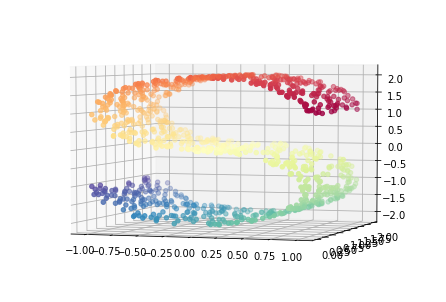

In [ ]:
from time import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn import manifold, datasets

n_points = 1000
X, color = datasets.make_s_curve(n_points, random_state=0)
n_neighbors = 10
n_components = 2

fig = plt.figure(figsize=(15, 8))

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
ax.view_init(4, -72)
plt.show()

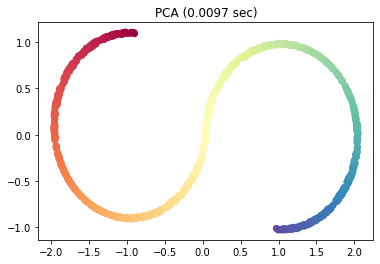

In [ ]:
t0 = time()

pca = PCA(n_components=2)
Y = pca.fit_transform(X)

t1 = time()

plt.figure()
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("PCA (%.2g sec)" % (t1 - t0))
plt.axis('tight')

plt.show()

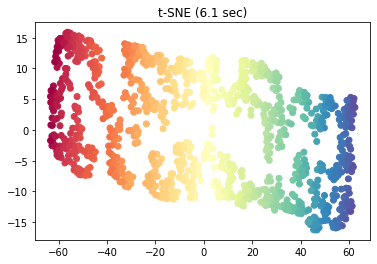

In [ ]:
t0 = time()
tsne = manifold.TSNE(n_components=n_components, init='pca', random_state=0)
Y = tsne.fit_transform(X)
t1 = time()

plt.figure()
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("t-SNE (%.2g sec)" % (t1 - t0))
plt.axis('tight')

plt.show()

#### On digits data: PCA vs LDA vs t-SNE

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
%%time
from sklearn.decomposition import PCA
pca = PCA(2)
X_pca = pca.fit_transform(digits.data)

CPU times: user 16.9 ms, sys: 25.2 ms, total: 42.1 ms
Wall time: 43.4 ms


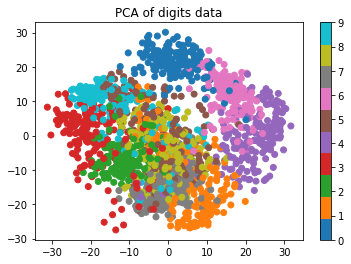

In [ ]:
plt.scatter(X_pca[:,0], X_pca[:,1], c=digits.target, cmap="tab10")
plt.title("PCA of digits data")
plt.colorbar()
plt.show()

In [ ]:
%%time
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=2)
X_lda = lda.fit_transform(digits.data, digits.target)

CPU times: user 35.1 ms, sys: 6.03 ms, total: 41.2 ms
Wall time: 30.6 ms


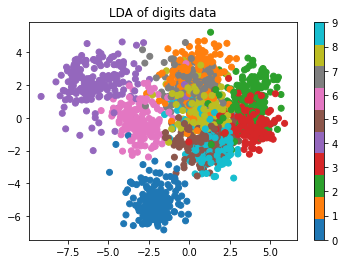

In [ ]:
plt.scatter(X_lda[:,0], X_lda[:,1], c=digits.target, cmap="tab10")
plt.title("LDA of digits data")
plt.colorbar()
plt.show()

In [ ]:
%%time
from sklearn import manifold
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(digits.data)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


CPU times: user 25.6 s, sys: 443 ms, total: 26 s
Wall time: 18.6 s


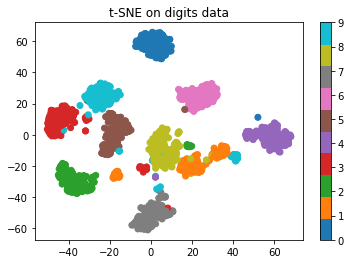

In [ ]:
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=digits.target, cmap="tab10")
plt.title("t-SNE on digits data")
plt.colorbar()
plt.show()

##### Reconstruction of original data: PCA vs t-SNE

In [ ]:
n_samples = 60

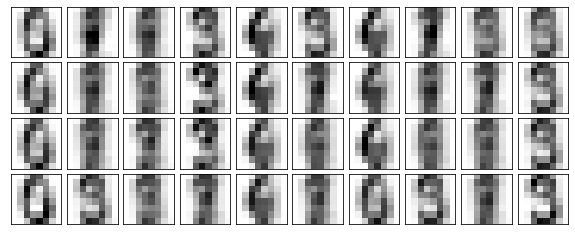

In [ ]:
plot_digits(pca.inverse_transform(X_pca[:n_samples]))

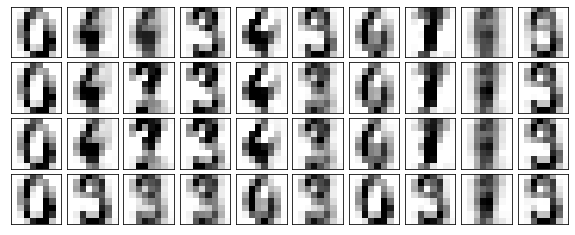

In [ ]:
plot_digits(pca.inverse_transform(X_tsne[:n_samples]))

#### Further resources
+ The original t-SNE paper:
  [L.J.P. van der Maaten and G.E. Hinton. Visualizing High-Dimensional Data Using t-SNE. Journal of Machine Learning Research 9, 2008](https://lvdmaaten.github.io/publications/papers/AISTATS_2009.pdf)
+ A more accessible [Google Techtalk introduction video](https://www.youtube.com/watch?v=RJVL80Gg3lA&list=UUtXKDgv1AVoG88PLl8nGXmw)

### Uniform Manifold Approximation and Projection (UMAP)

UMAP is a new manifold learning algorithm (published in 2018), which is claimed to produce results of similar (or even higher) quality to t-SNE but _a magnitude faster_.

The algorithm works by modeling the manifold by a fuzzy topological structure built on the basis of the neighborhood relationships and distances between the data points. This topological structure, in turn is represented by a _weighted graph between the data points_, e.g., the sinusoid-based data set 

<a href="https://umap-learn.readthedocs.io/en/latest/_images/how_umap_works_raw_data.png"><img src="https://drive.google.com/uc?export=view&id=1zPbSroeCkEh2Ox2UTdrozCLFGJ0T-rMH" width="500px"></a>

leads to the

<a href="https://umap-learn.readthedocs.io/en/latest/_images/how_umap_works_umap_graph.png"><img src="https://drive.google.com/uc?export=view&id=1VOPAItEtU57rlvziACngx3W7sGnGfTov" width="500px"></a>

weighted graph.

(Image source: [How UMAP works](https://umap-learn.readthedocs.io/en/latest/how_umap_works.html))

Having produced the weighted graph representation, UMAP, similarly to t-SNE, finds the best low-dimensional representation by _minimizing the cross-entropy_ between distributions corresponding to the source-domain graph and the target-domain data set using gradient descent.

Using a number of speed-up tricks (considering only close neighbors, using a smooth approximation of the objective etc.) UMAP manages to be significantly faster than t-SNE, e.g., on subsets of the MNIST data set the speed measurements (by the UMAP team) were:

<a href="https://umap-learn.readthedocs.io/en/latest/_images/performance_20_1.png"><img src="https://drive.google.com/uc?export=view&id=1GHnVzOoY1uiG-kmOG3f1hsMa2cCx7PBH" height="450px"></a>

(Image source: [How UMAP works](https://umap-learn.readthedocs.io/en/latest/how_umap_works.html))

#### Further resources

- [How UMAP works](https://umap-learn.readthedocs.io/en/latest/how_umap_works.html) -- a relatively easy-going description in the UMAP user guide.
- The UMAP paper: [UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction](https://arxiv.org/pdf/1802.03426)
- Official UMAP implementation: https://github.com/lmcinnes/umap

### Self Organizing Map (SOM)

* Developed in  the 1980s by Teuvo Kohonen Finnish AI researcher .
* Unsupervised method.
* Produces a nonlinear mapping from a high dimensional feature space to a low (typically two) dimensional __discrete__ map 
* Uses a neural network with a special topology and learning rule.



#### Neural network
 
A network for a mapping from an $n$-dimensional space consists of neurons arranged in the form of a 2- (or rarely 3-) dimensional map -- with each neuron having $n$ weights.

<a href="https://codesachin.files.wordpress.com/2015/11/kohonen1.gif"><img src="https://drive.google.com/uc?export=view&id=10TCnWjWz0d5R673rKhNFNdMBVLHrER0t"></a>

(image source: [Sachin Joglekar: SOMs with TensorFlow](https://codesachin.wordpress.com/2015/11/28/self-organizing-maps-with-googles-tensorflow/))

#### Training

<a href="https://upload.wikimedia.org/wikipedia/commons/thumb/9/91/Somtraining.svg/500px-Somtraining.svg.png"><img src="https://drive.google.com/uc?export=view&id=123JLLtNGrXuFGJAQO4c6kvypslNjQA-K"></a>

Training uses so called "competitive learning". Starting with a network with randomly initialized weights the following steps are performed for each data point:

* Find the neuron whose weights are closest to the data point -- this will be the current Best Matching Unit (BMU). 
* Adjust the weights of the BMU neuron to be closer to that data point. The amount of adjustment  is determined by a learning rate which decreases after each iteration.
* Also adjust the BMU’s neighbors' weights to be closer to that data point as well, with farther neighbors adjusted less. The "neigborhood radius" is also decreasing during training.

The above steps are repeated (typically many times for the whole data set) until the weights of the network stabilize.

<a href="http://drive.google.com/uc?export=view&id=1ehPHe86CXAS-eitjDN2GB2LPZl7Lgjif"><img src="https://drive.google.com/uc?export=view&id=1r6WAPCkllm7hhGRre-T3HiFojD751BgZ" width=65%></a>

[source](https://www.youtube.com/watch?v=abF_FdCb5OI)



#### Mapping

After training an input data point is mapped simply to the place of the BMU neuron.



#### Resulting Maps

In addition to arranging similar datapoints into clusters, SOMs are good at placing similar clusters close to each other.

Some examples:

Map taught with only 10 example colors as RGB triplets:

<a href="http://jjguy.com/som/somcolor-after.png"><img src="https://drive.google.com/uc?export=view&id=1fIQQOxaO4hxNt7QBknKjB4SoP6v5GCHE" width="500"></a>

(Image source: http://jjguy.com/som/ where the training process can be seen live)


Typical applications include mapping documents, e.g. this map does it with Wikipedia articles:
<a href="https://upload.wikimedia.org/wikipedia/commons/0/07/Self_oraganizing_map_cartography.jpg"><img src="https://drive.google.com/uc?export=view&id=1Bg2hOn233sE7uUm3CrHvLP3dgwONte2K" width="600"></a>

("mountains" are just cluster border visualisations)

(image source: https://en.wikipedia.org/wiki/Self-organizing_map)



#### Disadvantages

+ Training can be computationally expensive
+ The mapping is discrete
+ Does not work well with categorical data

#### Further reading

+ [Algobeans SOM tutorial](https://algobeans.com/2017/11/02/self-organizing-map/)
+ [Simple SOM training demos](http://jjguy.com/som/)





## Conclusion 

Though we tried to cover the more important forms of dimensionality reduction techniques, we can by no means claim full coverage, **many more techniques exist**. A nice summary of tips and methods can be found in the **[Ten quick tips for effective dimensionality reduction
](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1006907)**.

Some things to pay attention to when doing dimension reduction:

*   Features should be on the **same scale** (to be obsereved in general for distance-based algorithms!)
*   Finding the **optimal output dimension**.
  - E.g., PCA: refer to explained variance ratio
  - E.g., t-SNE: not more than 2 or 3
  - In general: reconstruct original data and measure the error of the reconstruction / for supervised tasks, check performance measure (always on on train data only!)

